## Closed Loop Simulation Notebook

This notebook breaks down the closed loop simulation in different jupyter notebook cells. The aim of this notebook is to ease the debugging and development of the different packages involved in the Optical Feedback Control loop.

This notebook was last run on Aug. 12th 2021. 
Details:
- Machine size: 32 CPUs, 16 cores per socket (2 sockets).
- Stack release: 2021_25, Last verified to run 2021-08-12
- ts_phosim release: v1.4.0


### Required python packages

In [1]:
import argparse
import logging
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.PlotUtil import plotFwhmOfIters
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import CamType, FilterType, runProgram
from lsst.ts.wep.ctrlIntf.SensorWavefrontData import SensorWavefrontData
from lsst.ts.phosim.Utility import getPhoSimPath, getAoclcOutputPath, getCamera

In [2]:
from tqdm import tqdm

### Default arguments and initializations

Initialize default arguments to run the closed loop and initialize the ClosedLoopTask

In [3]:
%%time

# Set the parser
parser = argparse.ArgumentParser(
    description="Run AOS closed-loop simulation (default is amplifier files)."
)
parser = CloseLoopTask.setDefaultParser(parser)
parser = CloseLoopTask.setImgParser(parser)

# Get the default arguments
sys.argv = ['-f']
args = parser.parse_args()

# Print default arguments
print(args)

logger = logging.getLogger()
logger.setLevel(args.log_level)

# Initialize the ClosedLoopTask
closeLoopTask = CloseLoopTask()

Namespace(boresightDeg=[0, 0], clobber=False, eimage=False, filterType='', inst='comcam', iterNum=5, log_level=20, m1m3FErr=0.05, numOfProc=1, output='', rotCam=0.0, skyFile='')
CPU times: user 3.52 ms, sys: 986 µs, total: 4.51 ms
Wall time: 3.49 ms


### Set paths and arguments

Customize the following arguments to run the simulation you are interested in. If not stated in the following code cell, the arguments are taken to be the default ones. Note that this paths should be changed if another user is running them and wants to change the directory addresses.

In [4]:
PHOSIMPATH = "/project/gmegias/aos/lsst_stack/phosim_syseng4/"
AOCLCOUTPUTPATH = "/project/gmegias/aos/lsst_stack/ts_phosim/output/"
os.environ["PHOSIMPATH"] = PHOSIMPATH
os.environ["AOCLCOUTPUTPATH"] = AOCLCOUTPUTPATH

In [5]:
args.inst = 'comcam' 
args.numOfProc = 32 
args.boresightDeg = [0.03, -0.02]
args.skyFile = '/project/gmegias/aos/lsst_stack/ts_phosim/tests/testData/sky/skyComCam.txt'
args.output = '/project/gmegias/aos/lsst_stack/perturbations/test/'

if os.path.exists(args.output):
    shutil.rmtree(args.output)

### Intializations and initial configurations

First, initialize the variables from the arguments dictionary.

In [6]:
boresight = args.boresightDeg
rotCamInDeg = args.rotCam
useEimg = args.eimage
m1m3ForceError = args.m1m3FErr
numPro = args.numOfProc
iterNum = args.iterNum
doErsDirCont = args.clobber
pathSkyFile = args.skyFile

Check and set the required configurations to run the simulation loop.

In [7]:
%%time

# Check the input arguments
camType, instName = closeLoopTask.getCamTypeAndInstName(args.inst)
filterType = closeLoopTask.getFilterType(args.filterType)
baseOutputDir = closeLoopTask.checkAndCreateBaseOutputDir(args.output)

if doErsDirCont:
    closeLoopTask.eraseDirectoryContent(baseOutputDir)

closeLoopTask.checkBoresight(boresight, args.skyFile)

closeLoopTask.assignImgType(useEimg)

# Configure the components
closeLoopTask.configSkySim(instName, pathSkyFile = args.skyFile, starMag=15)

pathIsrDir = closeLoopTask.createIsrDir(baseOutputDir)
closeLoopTask.configWepCalc(
    camType, pathIsrDir, filterType, boresight, rotCamInDeg, useEimg=useEimg
)

closeLoopTask.configOfcCalc(instName)
closeLoopTask.configPhosimCmpt(
    filterType, rotCamInDeg, m1m3ForceError, numPro
)

# Set the defocal distance for WEP calculator based on the setting
# file in the telescope
closeLoopTask.setWepCalcWithDefocalDist()

/project/gmegias/aos/lsst_stack/ts_wep/python/lsst/ts/wep/bsc/WcsSol.py:45: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  self._camera = obs_lsst.lsstCamMapper.LsstCamMapper().camera


CPU times: user 3min 2s, sys: 7.52 s, total: 3min 10s
Wall time: 3min 10s


### Generate butler gen3 repository.

In [8]:
%%time

# generate bluter gen3 repo if needed
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
if closeLoopTask.useCcdImg():
    closeLoopTask.generateButler(butlerRootPath, instName)
    closeLoopTask.generateRefCatalog(
        instName = instName,
        butlerRootPath = butlerRootPath,
        pathSkyFile = pathSkyFile,
    )
    
closeLoopTask.phosimCmpt.tele.setInstName(camType)

CPU times: user 22.4 ms, sys: 86.1 ms, total: 108 ms
Wall time: 3min 22s


### Simulation loop initialization

Initialize the state of the telescope to run the simulation. This cell also sets common file and directory names required for the closed loop simulation.

In [9]:
%%time

# Set the telescope state to be the same as the OFC
state0 = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(state0)

# Get the list of referenced sensor name (field positions)
refSensorNameList = closeLoopTask.getSensorNameListOfFields(instName)
refSensorIdList = closeLoopTask.getSensorIdListOfFields(instName)

# Common file and directory names
opdZkFileName = "opd.zer"
opdPssnFileName = "PSSN.txt"
outputDirName = "pert"
outputImgDirName = "img"
iterDefaultDirName = "iter"
dofInUmFileName = "dofPertInNextIter.mat"
fwhmItersFileName = "fwhmIters.png"

# Specific file names to the amplifier/eimage
wfsZkFileName = "wfs.zer"

CPU times: user 50.2 ms, sys: 3.86 ms, total: 54.1 ms
Wall time: 52.5 ms


### Define Phosim initalization functions

In [10]:
def _writePertAndCmdFiles(self, cmdSettingFileName, cmdFileName):
    # Write the perturbation file
    pertCmdFileName = "pert.cmd"

    pertCmdFilePath = os.path.join(self.outputDir, pertCmdFileName)
    tele = TeleFacade()
    if not os.path.exists(pertCmdFilePath):
        tele.writePertBaseOnConfigFile(
            self.outputDir,
            seedNum=self.seedNum,
            m1m3ForceError=self.m1m3ForceError,
            saveResMapFig=True,
            pertCmdFileName=pertCmdFileName,
        )

    # Write the physical command file
    cmdSettingFile = os.path.join(self.configDir, "cmdFile", cmdSettingFileName)
    cmdFilePath = os.path.join(self.outputDir, cmdFileName)
    if not os.path.exists(cmdFilePath):
        self.tele.writeCmdFile(
            self.outputDir,
            cmdSettingFile=cmdSettingFile,
            pertFilePath=pertCmdFilePath,
            cmdFileName=cmdFileName,
        )

    return cmdFilePath

def getOpdArgsAndFilesForPhoSim(
        phosimCmpt,
        instName,
        cmdFileName="opd.cmd",
        instFileName="opd.inst",
        logFileName="opdPhoSim.log",
        cmdSettingFileName="opdDefault.cmd",
        instSettingFileName="opdDefault.inst",
    ):
        """Get the OPD calculation arguments and files for the PhoSim
        calculation.
        OPD: optical path difference.
        Parameters
        ----------
        instName : `str`
            Instrument name.
        cmdFileName : str, optional
            Physical command file name. (the default is "opd.cmd".)
        instFileName : str, optional
            OPD instance file name. (the default is "opd.inst".)
        logFileName : str, optional
            Log file name. (the default is "opdPhoSim.log".)
        cmdSettingFileName : str, optional
            Physical command setting file name. (the default is
            "opdDefault.cmd".)
        instSettingFileName : str, optional
            Instance setting file name. (the default is "opdDefault.inst".)
        Returns
        -------
        str
            Arguments to run the PhoSim.
        """

        # Set the weighting ratio and field positions of OPD
        phosimCmpt.metr.setWgtAndFieldXyOfGQ(instName)

        # Write the command file
        cmdFilePath = _writePertAndCmdFiles(phosimCmpt, cmdSettingFileName, cmdFileName)

        # Write the instance file
        instSettingFile = phosimCmpt._getInstSettingFilePath(instSettingFileName)

        instFilePath = phosimCmpt.tele.writeOpdInstFile(
            phosimCmpt.outputDir,
            phosimCmpt.metr,
            instSettingFile=instSettingFile,
            instFileName=instFileName,
        )

        # Get the argument to run the PhoSim
        argString = phosimCmpt._getPhoSimArgs(logFileName, instFilePath, cmdFilePath)

        return argString
    
getOpdArgsAndFilesForPhoSim(closeLoopTask.phosimCmpt, instName)

'/home/gmegias/notebooks/opd.inst -i comcam -e 1 -c /home/gmegias/notebooks/opd.cmd -p 32 -o /home/gmegias/notebooks > /home/gmegias/notebooks/opdPhoSim.log 2>&1'

In [11]:
iterCount = 1
obsId = 9006000
# Set the observation Id
closeLoopTask.phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
closeLoopTask.phosimCmpt.setOutputDir(outputDir)

# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName, outputImgDirName)
closeLoopTask.phosimCmpt.setOutputImgDir(outputImgDir)

In [12]:
# Generate the OPD image
print("Preparing PhoSim....")
t0 = time.time()
argString = getOpdArgsAndFilesForPhoSim(closeLoopTask.phosimCmpt, instName)
ttl_time = time.time() - t0
print("PhoSim prepared, took {} seconds.".format(ttl_time))

Preparing PhoSim....
PhoSim prepared, took 0.007406473159790039 seconds.


In [13]:
print("Running PhoSim....")
t0 = time.time()
closeLoopTask.phosimCmpt.runPhoSim(argString)
ttl_time = time.time() - t0
print("PhoSim run, took {} seconds.".format(ttl_time))

Running PhoSim....
PhoSim run, took 109.80988454818726 seconds.


In [14]:
# Analyze the OPD data
# Rotate OPD in the reversed direction of camera
print("Analyzing OPD data....")
t0 = time.time()
closeLoopTask.phosimCmpt.analyzeOpdData(
    instName,
    zkFileName=opdZkFileName,
    rotOpdInDeg=-rotCamInDeg,
    pssnFileName=opdPssnFileName,
)
ttl_time = time.time() - t0
print("OPD data analyzed, took {} seconds.".format(ttl_time))

Analyzing OPD data....
OPD data analyzed, took 5.1651270389556885 seconds.


In [15]:
# Get the PSSN from file
pssn = closeLoopTask.phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = closeLoopTask.phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
print("Setting FWHM data...")
t0 = time.time()
fwhm, sensor_id = closeLoopTask.phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, refSensorIdList
)

closeLoopTask.ofcCalc.set_fwhm_data(fwhm, sensor_id)
ttl_time = time.time() - t0
print("FWHM data set, took {} seconds.".format(ttl_time))

Calculated PSSN is [0.98029371 0.98606982 0.98029371 0.98606982 0.98372946 0.98606982
 0.98159617 0.98606982 0.9802937 ].
GQ effective FWHM is 0.0844.
Setting FWHM data...
FWHM data set, took 0.001220703125 seconds.


### Define Wavefront Estimation functions

This re-definitiion is required to ensure WEP files are created in the correct directory.

In [16]:
def _calcWfErrFromImg(self, obsId, butlerRootPath, instName):
    snap=0
    simSeed=1000
    # Assign the entra- and intra-focal observation Id
    extraObsId = obsId + 1
    intraObsId = obsId + 2

    print('Setting argstring...')
    # Generate the defocal images
    argStringList = self.phosimCmpt.getPistonCamStarArgsAndFilesForPhoSim(
        extraObsId,
        intraObsId,
        self.skySim,
        simSeed=simSeed,
        cmdSettingFileName="starDefault.cmd",
        instSettingFileName="starSingleExp.inst",
    )

    print('Running PhoSim...')
    for argString in argStringList:
        print(f"PHOSIM CCD ARGSTRING: {argString}")
        self.phosimCmpt.runPhoSim(argString)

    print('Repackaging...')
    # Repackage the images based on the image type
    self.phosimCmpt.repackagePistonCamImgs(
        instName=instName if instName == "comcam" else "lsst", isEimg=self.useEimg
    )

    print('Ingesting images...')
    # Ingest images into butler gen3
    self.ingestData(butlerRootPath=butlerRootPath, instName=instName)

    print('Running runWep...')
    err = runWep(closeLoopTask, extraObsId, intraObsId, butlerRootPath, instName)

    return err
    
def writeWepConfiguration(self, instName):
    """Write wavefront estimation pipeline task configuration.
    Parameters
    ----------
    instName: `str`
        Name of the instrument this configuration is intended for.
    """

    butlerInstName = "ComCam" if instName == "comcam" else "Cam"

    with open(f"/project/gmegias/aos/lsst_stack/perturbations/test/{instName}Pipeline.yaml", "w") as fp:
        fp.write(
            f"""# This yaml file is used to define the tasks and configuration of
            # a Gen 3 pipeline used for testing in ts_wep.
            description: wep basic processing test pipeline
            # Here we specify the corresponding instrument for the data we
            # will be using.
            instrument: lsst.obs.lsst.Lsst{butlerInstName}
            # Then we can specify each task in our pipeline by a name
            # and then specify the class name corresponding to that task
            tasks:
            isr:
            class: lsst.ip.isr.isrTask.IsrTask
            # Below we specify the configuration settings we want to use
            # when running the task in this pipeline. Since our data doesn't
            # include bias or flats we only want to use doApplyGains and
            # doOverscan in our isr task.
            config:
              connections.outputExposure: 'postISRCCD'
              doBias: False
              doVariance: False
              doLinearize: False
              doCrosstalk: False
              doDefect: False
              doNanMasking: False
              doInterpolate: False
              doBrighterFatter: False
              doDark: False
              doFlat: False
              doApplyGains: True
              doFringe: False
              doOverscan: True
            generateDonutCatalogOnlineTask:
            class: lsst.ts.wep.task.GenerateDonutCatalogOnlineTask.GenerateDonutCatalogOnlineTask
            # Here we specify the configurations for pointing that we added into the class
            # GenerateDonutCatalogOnlineTaskConfig.
            config:
              boresightRa: {self.boresightRa}
              boresightDec: {self.boresightDec}
              boresightRotAng: {self.boresightRotAng}
            estimateZernikesFamTask:
            class: lsst.ts.wep.task.EstimateZernikesFamTask.EstimateZernikesFamTask
            config:
              # And here we specify the configuration settings originally defined in
              # EstimateZernikesFamTaskConfig.
              donutTemplateSize: 160
              donutStampSize: 160
              initialCutoutPadding: 40
            """
            )
    
def runWep(self, extraObsId, intraObsId, butlerRootPath, instName):
    
    butlerInstName = "ComCam" if instName == "comcam" else "Cam"

    butler = dafButler.Butler(butlerRootPath)

    if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():

        self.log.info("Ingesting curated calibrations.")

        runProgram(
            f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
        )

    print('Writing WEP configuration...')
    writeWepConfiguration(self, instName)

    print('Running WEP command...')
    try: 
        runProgram(
            f"pipetask run -b {butlerRootPath} "
            f"-i refcats,LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib "
            f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
            f"--register-dataset-types --output-run ts_phosim_{extraObsId} -p {instName}Pipeline.yaml -d "
            f'"exposure IN ({self.visitIdOffset+extraObsId}, {self.visitIdOffset+intraObsId})" -j 2'
        )

    except:
        # Need to redefine butler because the database changed.
        butler = dafButler.Butler(butlerRootPath)

        datasetRefs = butler.registry.queryDatasets(
            datasetType="zernikeEstimateAvg", collections=[f"ts_phosim_{extraObsId}"]
        )

        print('Setting Wf Errors...')
        listOfWfErr = []

        for dataset in datasetRefs:
            dataId = {
                "instrument": dataset.dataId["instrument"],
                "detector": dataset.dataId["detector"],
                "exposure": dataset.dataId["exposure"],
            }

            zerCoeff = butler.get(
                "zernikeEstimateAvg",
                dataId=dataId,
                collections=[f"ts_phosim_{extraObsId}"],
            )

            sensorWavefrontData = SensorWavefrontData()
            sensorWavefrontData.setSensorId(dataset.dataId["detector"])
            sensorWavefrontData.setAnnularZernikePoly(zerCoeff)

            listOfWfErr.append(sensorWavefrontData)

        return listOfWfErr

In [17]:
%%time

extraObsId = obsId + 1
intraObsId = obsId + 2     
listOfWfErr = _calcWfErrFromImg(closeLoopTask, obsId, butlerRootPath, instName)err

Setting argstring...
Running PhoSim...
PHOSIM CCD ARGSTRING: /project/gmegias/aos/lsst_stack/perturbations/test/iter1/pert/starExtra.inst -i comcam -e 1 -c /project/gmegias/aos/lsst_stack/perturbations/test/iter1/pert/star.cmd -p 32 -o /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/extra > /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/extra/starExtraPhoSim.log 2>&1
PHOSIM CCD ARGSTRING: /project/gmegias/aos/lsst_stack/perturbations/test/iter1/pert/starIntra.inst -i comcam -e 1 -c /project/gmegias/aos/lsst_stack/perturbations/test/iter1/pert/star.cmd -p 32 -o /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/intra > /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/intra/starIntraPhoSim.log 2>&1
Repackaging...
Ingesting images...
Running runWep...
Writing WEP configuration...
Running WEP command...
Setting Wf Errors...
CPU times: user 797 ms, sys: 294 ms, total: 1.09 s
Wall time: 19min 8s


### Record the wavefront error and save

In [18]:
# Record the wavefront error with the same order as OPD for the
# comparison
print('Recording wavefront error...')
t0 = time.time()
if closeLoopTask.useCcdImg():
    closeLoopTask.phosimCmpt.reorderAndSaveWfErrFile(
        listOfWfErr,
        refSensorNameList,
        getCamera(instName),
        zkFileName=wfsZkFileName,
    )
ttl_time = time.time() - t0
print('Wavefront error recorded. Took {} seconds.'.format(ttl_time))

# Calculate the DOF
print('Calculating DOF...')
t0 = time.time()
wfe = np.array(
    [sensor_wfe.getAnnularZernikePoly() for sensor_wfe in listOfWfErr]
)
sensor_ids = np.array(
    [sensor_wfe.getSensorId() for sensor_wfe in listOfWfErr]
)
ttl_time = time.time() - t0
print('DOF computed. Took {} seconds.'.format(ttl_time))

print('Calculating corrections...')
t0 = time.time()
closeLoopTask.ofcCalc.calculate_corrections(
    wfe=wfe,
    field_idx=sensor_ids,
    filter_name=str('R'),
    gain=-1,
    rot=rotCamInDeg,
)
ttl_time = time.time() - t0
print('Corrections computed. Took {} seconds.'.format(ttl_time))

# Set the new aggregated DOF to phosimCmpt
print('Setting and saving new DOF...')
t0 = time.time()
dofInUm = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(dofInUm)

# Save the DOF file
closeLoopTask.phosimCmpt.saveDofInUmFileForNextIter(
    dofInUm, dofInUmFileName=dofInUmFileName
)
ttl_time = time.time() - t0
print('New DOF saved. Took {} seconds.'.format(ttl_time))

# Add the observation ID by 10 for the next iteration
obsId += 10

Recording wavefront error...
Wavefront error recorded. Took 0.0060577392578125 seconds.
Calculating DOF...
DOF computed. Took 0.0006766319274902344 seconds.
Calculating corrections...
Corrections computed. Took 0.38671398162841797 seconds.
Setting and saving new DOF...
New DOF saved. Took 0.0014832019805908203 seconds.


The wavefront error of the first simulation iteration is printed below

In [19]:
print(wfe)

[[-0.07105599 -0.03728988  0.37645333  0.0392639   0.02995426  0.04551182
   0.01198682  0.00934649 -0.00504794  0.00705704 -0.03145979 -0.00290473
  -0.00662934 -0.03047965 -0.00306473  0.01636482  0.00602967 -0.05231028
   0.01354332]
 [-0.06230934 -0.2065775   0.17485962 -0.06873055 -0.06191447 -0.03457004
   0.03365075  0.00360472 -0.01452705  0.03408544  0.00394021  0.01627989
   0.01957985  0.01047506  0.00192995  0.0235407  -0.01778855 -0.0482896
   0.01289665]
 [-0.0462198   0.02189774  0.10332987  0.03663608  0.03398097 -0.06631284
   0.04531734  0.01103811 -0.01799035  0.00159723  0.02202471  0.00948923
   0.00571454 -0.01524594 -0.00707417  0.03208727  0.00819737 -0.05304637
   0.01122915]
 [-0.07797821 -0.00307038  0.29817786  0.09682685  0.01593729 -0.01681193
   0.05598997  0.02019995  0.0066778  -0.01072547  0.00344295 -0.00214571
  -0.0044591  -0.03545741 -0.01047244  0.0302643  -0.02453261 -0.05857955
   0.01280486]
 [-0.06512966  0.24227659  0.13571211 -0.03676353  0.

### Summarize the FWHM and plot results

In [32]:
# Summarize the FWHM
pssnFiles = [
    os.path.join(
        baseOutputDir,
        "%s%d" % (iterDefaultDirName, num),
        outputImgDirName,
        opdPssnFileName,
    )
    for num in [0]
]
saveToFilePath = os.path.join(baseOutputDir, fwhmItersFileName)

Saved fig as 1.png


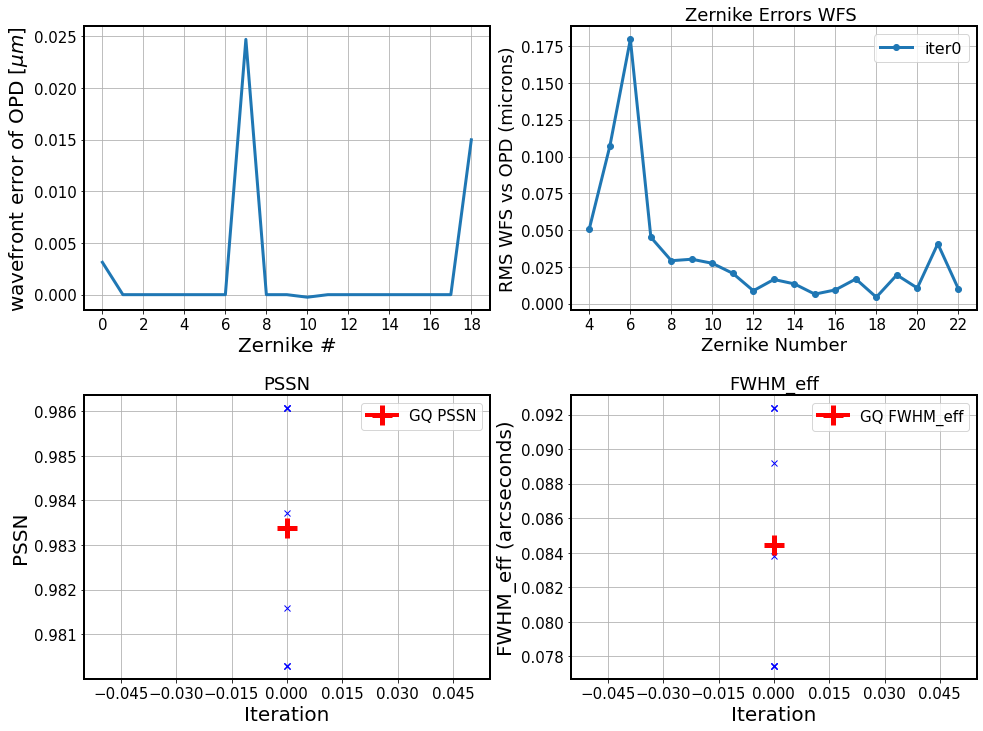

In [37]:
import analysis as at
import astropy.io.fits as fits
import imp
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18 

sys.path.append('/project/gmegias/aos/lsst_stack')
data_dir = '/project/gmegias/aos/lsst_stack/perturbations/test/'

at.plotIterationSummary(data_dir, iterNum=1,)